### Importing Libraries

In [4]:
# importing required libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Utility Functions

In [5]:
# Utility function to plot images
# Created by Kaushal Raj Mishra - https://github.com/kaushu42
def plot_grid(images, n_rows=4, n_cols=4, figsize=(5, 5), randomize=True, cmap="gray"):
    if randomize:
        images = images.copy()
        np.random.shuffle(images)
    fig = plot.figure(figsize=figsize)
    grid = ImageGrid(
            fig, 111,
            # creates 2x2 grid of axes
            nrows_ncols=(n_rows, n_cols), 
            # pad between axes in inch.
            axes_pad=0.1,  
        )
    for ax, im in zip(grid, iter(images)):
        ax.imshow(im, cmap=cmap)

### File Paths

In [6]:
# Paths to locate static files
DATASET_PATH = "FER2013.csv"
HAARCASCADE_PATH = "haarcascade_frontalface_default.xml"

### Reading the data from Dataset

In [7]:
# creating a datafram fetching the data from the dataset
dataframe = pd.read_csv(DATASET_PATH)

In [8]:
# Getting the summary of dataset
print(dataframe.Usage.value_counts())

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64


Text(0, 0.5, 'Count')

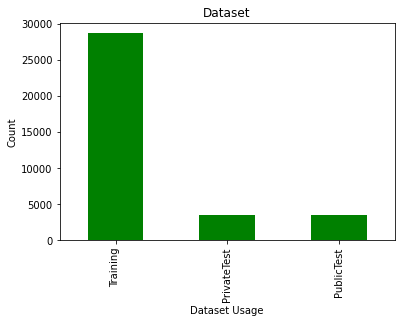

In [9]:
# Getting the total ditribution of images based on usage and plotting in the graph
dataframe.Usage.value_counts().plot.bar(color="green")
plot.title("Dataset")
plot.xlabel("Dataset Usage")
plot.ylabel("Count")

Text(0, 0.5, 'Count')

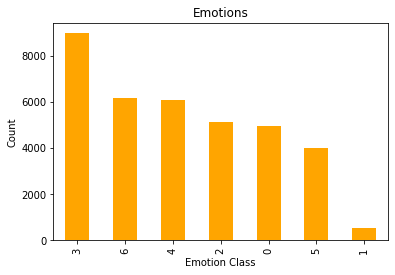

In [10]:
# Getting the distribution of emotion class and plotting in the graph
dataframe.emotion.value_counts().plot.bar(color="orange")
plot.title("Emotions")
plot.xlabel("Emotion Class")
plot.ylabel("Count")

### Conversion, Allocation and Normalization of data

In [11]:
# Defining a funciton to convert the pixel strings into integers
def convert_pixels(pixels_string):
#     returning a converted int pixels value 
    return np.fromstring(pixels_string, dtype=int, sep=" ").reshape(48, 48, 1)

# assigning converted pixel values into dataframe
# appy function is used to converted each sting pixels into int
dataframe["px_array"] = dataframe.pixels.apply(convert_pixels)

In [12]:
# Assiging the training and testing data based on Usage column on the dataset
train_data = dataframe.query("Usage == 'Training'")
test_data = dataframe.query("Usage != 'Training'")

In [13]:
# Normalizing the data for training set
x_train = np.stack(train_data.px_array)/255
y_train = train_data.emotion

# Normalizing the data for test set
x_test = np.stack(test_data.px_array)/255
y_test = test_data.emotion

In [14]:
# Plotting the summary of images from dataset using utility functions
# plot_grid(x_train, 5,5)

In [15]:
# One-Hot Encoding train and test data set to get a single emotion with high probability
y_train_catg = to_categorical(y_train)
y_test_catg = to_categorical(y_test)

### Data Augmetation

In [16]:
# Generating extra images by modifying the properties of data in exsiting dataset
# This is done to increase the data size for a better trained model
image_generator = ImageDataGenerator(
        rotation_range=5,  
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        zoom_range = 0.1,
        shear_range = 10,  
        horizontal_flip=True, 
        validation_split=0.2
)

# Allocating the augmented data to training and testing sets
train_iterate = image_generator.flow(x_train, y_train_catg, batch_size=128, subset='training')
val_iterate = image_generator.flow(x_train, y_train_catg, batch_size=128, subset='validation')  

# Iterating on genrator object to generate iamge data
gen_x, gen_y = next(train_iterate)

### Creating CNN Model

In [17]:
# Clearing previous models and sessions
clear_session()

# Defining model layers
input_layer = Input(shape=(48, 48, 1))
layers = Conv2D(64, 3, 1, activation="relu", padding="same")(input_layer)
layers = BatchNormalization()(layers)
layers = MaxPooling2D()(layers)
layers = Dropout(0.25)(layers)

layers = Conv2D(128, 3, 1, activation="relu", padding="same")(layers)
layers = BatchNormalization()(layers)
layers = MaxPooling2D()(layers)
layers = Dropout(0.25)(layers)

layers = Conv2D(512, 3, 1, activation="relu", padding="same")(layers)
layers = BatchNormalization()(layers)
layers = MaxPooling2D()(layers)
layers = Dropout(0.25)(layers)

layers = Conv2D(512, 3, 1, activation="relu", padding="same")(layers)
layers = BatchNormalization()(layers)
layers = MaxPooling2D()(layers)
layers = Dropout(0.25)(layers)

layers = Flatten()(layers)
layers = Dense(256, activation="relu")(layers)
layers = BatchNormalization()(layers)
layers = Dropout(0.25)(layers)

layers = Dense(512, activation="relu")(layers)
layers = BatchNormalization()(layers)
layers = Dropout(0.25)(layers)
layers = Dense(7, activation="softmax")(layers)

# Defining input, hidden and output layers
model = Model(inputs=[input_layer], outputs=[layers])
# Showing the summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512   

In [18]:
# Defining callbacks for the model while training
# param: patience - iterations to wait before stopping when val loss is not improving
my_callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]

In [19]:
# Plotting the model architecture
plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Compiling and Training the Model

In [20]:
# Compiling the created model
# Params : loss = loss function
# optimizer : optimizer type to be used
# metrics : Metrics to be shown while training the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Calculating class weights for balanced distribution of emotions classes
weights = compute_class_weight('balanced',np.unique(y_train),y_train)
# Enumerating weights in the form of dictionary
weights = dict(enumerate(weights))

e:\ai\ai-env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=0        0
1        0
2        2
3        4
4        6
        ..
28704    2
28705    0
28706    4
28707    0
28708    4
Name: emotion, Length: 28709, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [26]:
# Training the model
# Params : epochs - number of epochs
# batch_size : batch size of the train data
# class_weight : weights for the classes
# validation_data: validation data set
# callbacks : callbacks to run while training the model
train_model = model.fit(train_iterate, epochs=100, batch_size=128, class_weight=weights, validation_data=val_iterate, callbacks=my_callbacks)

Epoch 1/100
180/180 [==============================] - 22s 76ms/step - loss: 2.5006 - accuracy: 0.1574 - val_loss: 5.6661 - val_accuracy: 0.0141
Epoch 2/100
180/180 [==============================] - 13s 72ms/step - loss: 2.1000 - accuracy: 0.1781 - val_loss: 2.1069 - val_accuracy: 0.1787
Epoch 3/100
180/180 [==============================] - 13s 71ms/step - loss: 2.0251 - accuracy: 0.1890 - val_loss: 1.9392 - val_accuracy: 0.2188
Epoch 4/100
180/180 [==============================] - 13s 71ms/step - loss: 1.9283 - accuracy: 0.2192 - val_loss: 1.8662 - val_accuracy: 0.2357
Epoch 5/100
180/180 [==============================] - 13s 70ms/step - loss: 1.8326 - accuracy: 0.2473 - val_loss: 1.8565 - val_accuracy: 0.2545
Epoch 6/100
180/180 [==============================] - 13s 70ms/step - loss: 1.7607 - accuracy: 0.2846 - val_loss: 1.7054 - val_accuracy: 0.3329
Epoch 7/100
180/180 [==============================] - 13s 71ms/step - loss: 1.7199 - accuracy: 0.3276 - val_loss: 1.7263 - val_ac

### Saving the Model

In [27]:
# Saving the model
model.save("Model.h5")

### Training Report

In [37]:
# Evaluating the trained model using test data
model.evaluate(x_test, y_test_catg)

225/225 [==============================] - 1s 6ms/step - loss: 1.0182 - accuracy: 0.6222


[1.0181841850280762, 0.622178852558136]

In [38]:
# Getting the training and validation loss and accuracy from the model
training_loss = train_model.history["loss"]
validation_loss = train_model.history["val_loss"]
training_acc = train_model.history["accuracy"]
validation_acc = train_model.history["val_accuracy"]

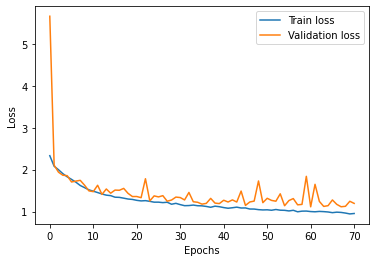

In [39]:
# Plotting the training and validation loss in the graph using matplotlib
plot.plot(training_loss, label="Train loss")
plot.plot(validation_loss, label="Validation loss")
plot.ylabel('Loss')
plot.xlabel('Epochs')
plot.legend()

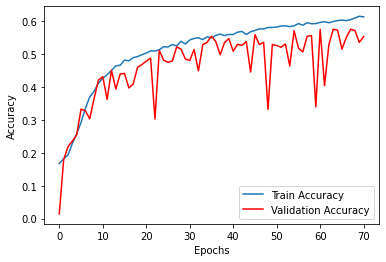

In [40]:
# Plotting the training and validation accuracy in the graph using matplotlib
plot.plot(training_acc, label="Train Accuracy")
plot.plot(validation_acc, label="Validation Accuracy", color="red")
plot.ylabel('Accuracy')
plot.xlabel('Epochs')
plot.legend()

### Training Statistics

In [41]:
# Defining a list to store the emotion strings based on their class index from dataset
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [42]:
# Predictions and reports on Training data
predictions = model.predict(x_train).argmax(axis=1)
print(classification_report(y_train, predictions))
print(confusion_matrix(y_train, predictions))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57      3995
           1       0.48      0.90      0.62       436
           2       0.63      0.34      0.44      4097
           3       0.89      0.83      0.86      7215
           4       0.53      0.57      0.55      4830
           5       0.76      0.81      0.78      3171
           6       0.53      0.75      0.62      4965

    accuracy                           0.66     28709
   macro avg       0.63      0.68      0.64     28709
weighted avg       0.67      0.66      0.65     28709

[[2083  156  190  158  570   83  755]
 [  15  394    3    3   14    2    5]
 [ 459  104 1412  125  920  497  580]
 [ 110   29   52 5981  269  141  633]
 [ 344   72  327  106 2759   45 1177]
 [  71   40  168  147   50 2555  140]
 [ 213   33  102  224  612   57 3724]]


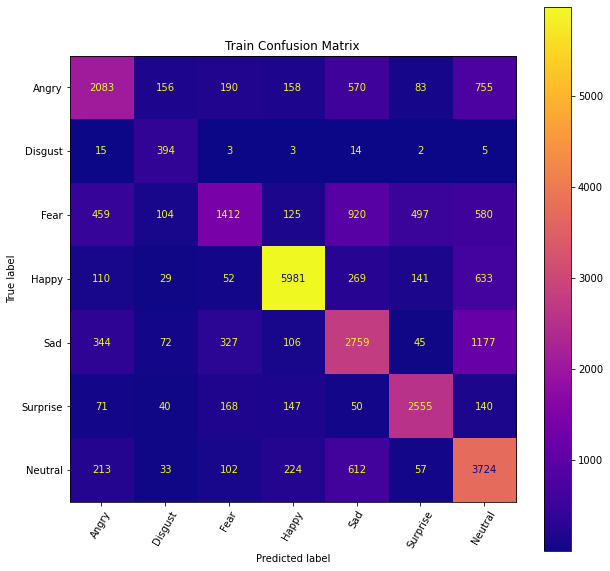

In [43]:
# Graphically representing the confusion matrix 
confusion_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, predictions),display_labels=emotions)
# changing the size of the graph
_, ax = plot.subplots(figsize=(10, 10))
# Setting the title for the graph
plot.title("Train Confusion Matrix")
# setting extra attributes for customizations
confusion_matrix_plot = confusion_matrix_plot.plot(include_values=True,cmap="plasma",xticks_rotation="60.0",ax=ax,values_format='d')

In [44]:
# Predictions and reports on Testing data
predictions = model.predict(x_test).argmax(axis=1)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.52      0.55       958
           1       0.38      0.65      0.48       111
           2       0.55      0.29      0.38      1024
           3       0.88      0.80      0.84      1774
           4       0.49      0.53      0.51      1247
           5       0.73      0.77      0.75       831
           6       0.50      0.71      0.59      1233

    accuracy                           0.62      7178
   macro avg       0.59      0.61      0.58      7178
weighted avg       0.64      0.62      0.62      7178

[[ 499   50   50   30  130   28  171]
 [  17   72    1    2   10    2    7]
 [ 118   28  296   41  249  127  165]
 [  24    7   23 1424   89   37  170]
 [ 101   12   86   36  657   24  331]
 [  30   10   36   39   32  639   45]
 [  54   10   48   50  173   19  879]]


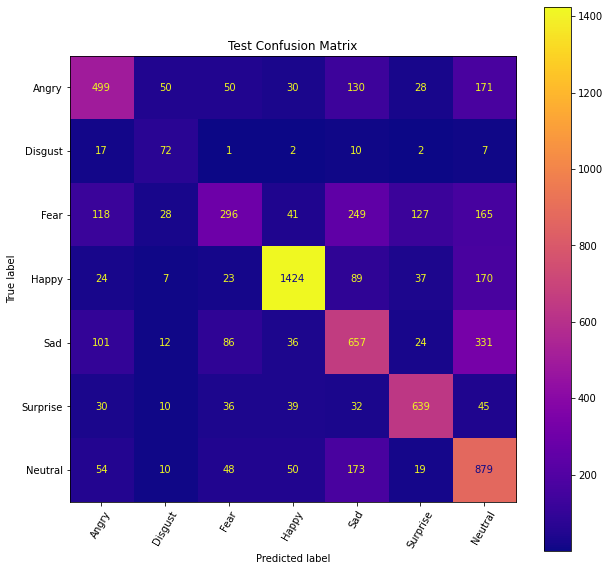

In [45]:
# Graphically representing the confusion matrix 
confusion_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions),display_labels=emotions)
# changing the size of the graph
_, ax = plot.subplots(figsize=(10, 10))
# Setting the title for the graph
plot.title("Test Confusion Matrix")
# setting extra attributes for customizations
confusion_matrix_plot = confusion_matrix_plot.plot(include_values=True,cmap="plasma",xticks_rotation="60.0",ax=ax,values_format='d')

### Testing Model for Single Image

Actual:  Angry
Predicted:  Angry


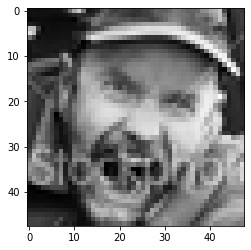

In [61]:
# Index of the image in dataset to test
test_index = 1800
# Getting the image from the dataset from given index
test_image = x_test[test_index].reshape(48, 48)
# Showing the selected image
plot.imshow(test_image,cmap="gray")
# Showing the predicted class and actual class of emotions for the selected image
print("Actual: ",emotions[np.stack(y_test)[test_index]])
print("Predicted: ",emotions[predictions[test_index]])

### --------------------------------------------------------------------------------------------------

# Live Testing the Saved Model

### --------------------------------------------------------------------------------------------------

### Importing Libraries

In [21]:
# Importing required libraries
import cv2 as cv
import numpy as np
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image

### Setting up Faces Detection

In [22]:
# Defining a list to store the emotion strings based on their class index from dataset
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
# Using haar cascade classifiers to extract the face from the images from camera
f_classifier = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

### Loading the Trained Model

In [23]:
# Loading the saved trained model for expression detection
model = load_model("Model.h5")

### Starting Camera and Detecting Facial Expressions

#### Press 'x' to Exit Camera

In [24]:
# Starting the default device camera using cv2
camera = cv.VideoCapture(0)

# Starting while loop to continuously read objects from camera
while True:
    #  Reading image from camera
    _, camera_frame = camera.read()
    # Getting face from the image and coverting it to grayscale image
    gray = cv.cvtColor(camera_frame,cv.COLOR_BGR2GRAY)
    # Detecting faces seen on the camera image
    faces = f_classifier.detectMultiScale(gray,1.3,5)
    # Adding text to the window to display the number of faces detected
    cv.putText(camera_frame, f'{len(faces)} Faces Found', (20, 25), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv.LINE_AA) 
    cv.putText(camera_frame, "Press 'x' To Exit", (500, 25), cv.FONT_HERSHEY_SIMPLEX,  0.5, (0, 255, 0), 2, cv.LINE_AA) 
    for (x,y,w,h) in faces:
        # Drawing bounding box around face and extreacting the image
        cv.rectangle(camera_frame,(x,y),(x+w,y+h),(0,0,255),2)
        # Extracting the face from the image
        gray_roi = gray[y:y+h,x:x+w]
        gray_roi = cv.resize(gray_roi,(48,48),interpolation=cv.INTER_AREA)
        # rect,face,image = face_detector(camera_frame)
        if np.sum([gray_roi])!=0:
            region_of_int = gray_roi.astype('float')/255.0
            region_of_int = img_to_array(region_of_int)
            region_of_int = np.expand_dims(region_of_int,axis=0)
            # make a prediction on the region_of_int, then lookup the class
            preds = model.predict(region_of_int)[0]
            # Defining labels of emotions
            emotion_label=emotions[preds.argmax()]
            label_position = (x,y)
            # Showing emotion text
            cv.putText(camera_frame,emotion_label,label_position,cv.FONT_HERSHEY_SIMPLEX,1,(0,255,255),3)
    # Displaying the camera output in a window
    cv.imshow('Facial Expressions Detection',camera_frame)
    # Defining exit key for the camera window ('x' in this case) and breaking the loop
    if cv.waitKey(1) & 0xFF == ord('x'):
        break
        
# Releasing all the camera resources and windows used by cv2
camera.release()
cv.destroyAllWindows()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
